## Object based training and classification using machine learning
----------------------

### A simple land cover mapping example using aerial photography 

The following workflow demonstrates using image segmentation and machine learning to produce landcover classes, the priniciples of which broadly apply to much remote sensing work. This was produced as an example to demostrate a landcover map for input to the ALMRS project. Image segmentation is often used to reduce noisy/detailed imagery to lancover classes greater in spatial coverage than the detail within the image. 

This kind of task is typical of that performed in environmental remote sensing by academic, research and commercial entities to map large areas but will always require QA/correction no matter the complexity of the approach. 

The data:

- Colour infra-red imagery collected over ther Arun Valley, Sussex (G, R, NiR)

- shapefiles of the training samples

Dependencies :

The code below uses geospatial-learn a library developed by Ciaran Robb to apply machine learning libraries to geospatial data. 

https://github.com/Ciaran1981/geospatial-learn

Whilst it is possible to use matplotlib to visualise some results in this notebook, QGIS 3 offers a more versatile platform for this purpose for the final datasets, so please ensure this is installed. Once installed, install the HCMGIS plugin to use various web-based base-layers for visualisation purposes. 

OTB is used briefly to segment the imagery via the command line:

https://anaconda.org/orfeotoolbox/otb

**Assumed knowledge:**

Basic GIS, image processing, remote sensing, python and command line use

Remember to query function args open a new cell (the plus icon) and write the function with a question mark - i.e

```python 
learning?
```
The lines of code have been written with readability in mind making each step as clear as possible, hence they are obviously not the briefest/most efficient way of doing things!

The principal lib used here is geospatial_learn, on which there are further details below. This script will train and classify polygon attributes. This task could be performed with a number of other libs most notable RSGISlib and Orfeo toolbox, on which there is plenty of online material. 

**Disclaimer! I do not claim this is good model or set of classes!!** 

**This is merely to demonstrate the funtionality on a segmentation derived from fine spatial resolution data**

Obviously, the reality of this type of approach is using large training sets and lengthier model parameter searches are required, as datasets are bigger than this small demonstration. 

**The Data**

The data is temporarily found here until QinetiQ find somewhere to store it and is the LandCover.zip file.

https://drive.google.com/open?id=1eM5pwMMwLSzp7S3fr-NJr6pzDi3tD0n3

The zip contains:

- Arundel_WWT.tif (a Green/Red/NIR composite)
- Arundel_train.gz (a compressed scikit-learn training array for the later pixel based training)
- ArunLcover.qml (a QGIS colour map for the results)
- Arundel_seg_empty.shp (the result of segmentation performed in this analysis complete with training labels)




In [1]:
%matplotlib inline

### Module imports
----------------------

As mentioned above, the code above imports the modules required for this image classification workflow, using the Object-based image analysis method on polygonal data.

Here are the links for the underlying libs:
- numpy (array processing) 
    http://www.numpy.org/
- matplotlib (plotting and graphics)
    https://matplotlib.org/    
- gdal (geospatial processing)
    http://www.gdal.org/
- scikit-learn (one of the main machine learning libs used in geospatial-learn).
    https://scikit-learn.org/

The final module, geospatial learn for applying machine learning libraries to geospatial data. I also includes some other geospatial functions for raster and vector data. 

Info on installation can be found here:

https://github.com/Ciaran1981/geospatial-learn




In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gdal
from geospatial_learn import learning, shape, raster
import shapefile

xgb not available


/bigdrive/anaconda3/lib/python3.5/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [ ]:
cd 'my/path/LandCover'

### Input file paths

In [3]:
msRas = ('Arundel_WWT.tif')

segShape = ('Arundel_seg_empty.shp')


### Calculate stats for segmentation

Using an otb generated segmentation....

You could alternatively use otb commands, monteverdi or qgis. 

The otb command for reference

```bash
otbcli_Segmentation -in path/to/image -filter meanshift -filter.meanshift.spatialr 5 -filter.meanshift.ranger 10 
-filter.meanshift.minsize 50 -mode vector -mode.vector.out path/to/outShape
```                     

We prefix the command line with ! to execute in this notebook as this is external to python

**Only run this if you wish to either experiment with parameters and/or wish to label the training segments yourself! Uncomment if this is the case.**

In [ ]:
#!otbcli_Segmentation -in path/to/image -filter meanshift -filter.meanshift.spatialr 5 -filter.meanshift.ranger 10 -filter.meanshift.minsize 50 -mode vector -mode.vector.out path/to/outShape

### Collection of statistics
----------------------------

Segment attribute data is written to the labeled shapefile using the shape.zonal_stats and shape.texture_stats function from geospatial_learn.

Rather than repeat the same line of code for each band, a simple for loop is used below to extract the band data.


In [4]:
# zonal stats
# please note that by using enumerate we assume the bandnames are ordered as the are in the image!
bandnames = ['g', 'r', 'nir']


# Please note we add 1 to the bnd index as python counts from zero
for bnd,name in enumerate(bandnames):
    shape.zonal_stats(segShape, msRas, bnd+1, name+'mn', stat = 'mean', write_stat = True)
    shape.zonal_stats(segShape, msRas, bnd+1, name+'mdn', stat = 'median', write_stat = True)
    shape.zonal_stats(segShape, msRas, bnd+1, name+'skw', stat = 'skew', write_stat = True)
    shape.zonal_stats(segShape, msRas, bnd+1, name+'krt', stat = 'kurtosis', write_stat = True)
    
   

  0%|          | 0/5768 [00:00<?, ?it/s]/bigdrive/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
100%|██████████| 5768/5768 [00:09<00:00, 636.73it/s]


In [5]:
# texture props
bandnames = ['g', 'r', 'nir']

for bnd,name in enumerate(bandnames):
    shape.texture_stats(segShape, msRas,  bnd+1,  gprop='entropy',  write_stat=True)



100%|██████████| 5768/5768 [00:07<00:00, 769.32it/s]


In [6]:
# shape props

props = ['MajorAxisLength', 'MinorAxisLength', 'Area', 'Eccentricity', 'Solidity',
         'Extent', 'Perimeter']
for prop in props:
    shape.shape_props(segShape, prop, label_field = 'DN')

  0%|          | 20/5768 [00:00<00:28, 199.04it/s]

Loading & prepping data
calculating stats


  2%|▏         | 99/5768 [00:00<00:05, 983.40it/s]

Loading & prepping data
calculating stats


  3%|▎         | 171/5768 [00:00<00:03, 1700.13it/s]

Loading & prepping data
calculating stats


  1%|▏         | 86/5768 [00:00<00:06, 859.81it/s]

Loading & prepping data
calculating stats


  5%|▍         | 267/5768 [00:00<00:02, 2666.24it/s]

Loading & prepping data
calculating stats


  5%|▍         | 270/5768 [00:00<00:02, 2693.97it/s]

Loading & prepping data
calculating stats


  0%|          | 0/5768 [00:00<?, ?it/s]

Loading & prepping data
calculating stats


100%|██████████| 5768/5768 [00:02<00:00, 2206.41it/s]


### Model training

Now that we have collected our training statistics, we can calibrate our chosen model, which, in this case is a random forest.

Geospatial_learn wraps scikit-learn (hence the name) and xgboost, two excellent machine learning libraries (I intend to add tensor flow to this shortly also!).

Typically, we collect training from a shapefile and save it as a .gz file with the get_training_shp function, though it is possible to feed the training array straight into the create_model function.

The label and feature fields respectively. 

```python

   label_field = 'Train'

   feat_fields = ['gmn','gmdn','gskw','gkrt','rmn','rmdn','rskw','rkrt','nirmn','nirmdn',
                  'nirskw','nirkrt','entropy','entropy_1','entropy_2']
```

Path to the training array we intend to save. This is optional, it is possible to run

```python

   training = '/savemytraining.gz'
```


```python

   dfTrain, rejects = learning.get_training_shp(segShape, label_field, feat_fields,  outFile = training)
```



### Motivational lazyness

**Here is a quick way of getting a list of the fields to be used as features in the training and classification without typing them out**

Here a list comprehension is used with the pyshp (shapefile) lib. This is not really that important, but if you are interested, it is a useful python concept....

If you are not familiar with list comprehensions, here is an attempt at explanation in the context of the shapefile. List comprehensions are useful, comapct and readable way of performing an operation on data.

The shapefile is read in as a python class object. A class is a fundamental part of object-based programming  (nothing to with the current task!!!) where the data structure has: 

* properties - effectively attributes of the data

* methods - built in operations on the data

Below r is the 'object' read in by the pyshp library

```python

r = shapefile.Reader(segShape)
```
The shapefile has a 'fields' property, but this returns a list in which each entry has the field name, datatype length, value. So each entry contains superfluous info:
```python

 ["AREA", "N", 18, 5],

```

Where as we are only interested in the first part of every entry, which is the field name. 

so this code is basically saying, output the first part (f[0]) of each entry (f) in the fields property (r.fields)

```python
[f[0] for f in r.fields]
```
Hence we end up with a list of only the field titles. Which gives us the names of all the properties.

Finally we exclude the DN and Train fields by indexing.

```python
feat_fields[3:25]
```


In [11]:
r = shapefile.Reader(segShape)

In [12]:
feat_fields = [f[0] for f in r.fields]
feat_fields = feat_fields[3:25]
feat_fields


['gmn',
 'gmdn',
 'gskw',
 'gkrt',
 'rmn',
 'rmdn',
 'rskw',
 'rkrt',
 'nirmn',
 'nirmdn',
 'nirskw',
 'nirkrt',
 'entro1',
 'entro2',
 'entro3',
 'MjAxis',
 'MnAxis',
 'Area',
 'Eccen',
 'Solid',
 'Extent',
 'Perim']

In [8]:
len(feat_fields)

22

### Now to create some training samples

These can be used in both a pixel and object based manner

The variables returned are a dataframe (like in R) and a list of reject polygons which may have had invalid geometry.

In practice there shouldn't be many of these - it's just to make sure!

In [9]:
training = 'Arundel_train_ob.gz'

label_field = 'Train'

dfTrain, rejects = learning.get_training_shp(segShape, label_field, feat_fields,  outFile = training)

 13%|█▎        | 752/5768 [00:00<00:00, 7517.70it/s]

Loading & prepping data
calculating stats


100%|██████████| 5768/5768 [00:00<00:00, 9059.06it/s]


Here's a quick look at the returned dataframe to see the information. Dataframes are handy to visualise in jupyter and ipython. The create_model accepts the raw array data though so the .as_matrix() property of the dataframe is used when inputting to create_model

The first column is the label, the rest features

In [10]:
dfTrain.head()

,Train,gmn,gmdn,gskw,gkrt,rmn,rmdn,rskw,rkrt,nirmn,...,entro1,entro2,entro3,MjAxis,MnAxis,Area,Eccen,Solid,Extent,Perim
0,NaN,23.137405,22.0,0.794978,0.345237,32.656489,33.0,-0.339259,0.014900,49.778626,...,4.066501,4.066501,4.066501,10.5,6.5,32.75,0.619048,0.673993,0.479853,35.0
1,NaN,163.718954,165.0,-0.511758,-0.266084,124.248366,125.0,-0.381341,0.275526,138.575163,...,4.010455,4.010455,4.010455,9.0,6.5,38.25,0.722222,0.811966,0.653846,34.0
2,NaN,40.714286,37.0,1.439138,2.549059,66.028571,64.0,0.227215,-0.648337,85.057143,...,3.734799,3.734799,3.734799,7.5,4.5,26.25,0.600000,0.888889,0.777778,26.0
3,NaN,142.213675,149.0,-0.801954,0.283542,209.829060,224.0,-0.821063,-0.390233,206.042735,...,3.677674,3.677674,3.677674,7.0,6.0,29.25,0.857143,0.851190,0.696429,30.0
4,NaN,76.803571,71.0,0.146892,-1.190404,58.880952,54.5,0.348225,-0.931439,75.750000,...,4.098618,4.098618,4.098618,9.5,6.0,42.00,0.631579,0.822368,0.736842,32.0


### Model creation with k-fold cross validated grid search

Now we can train the model with the above data.

We first define the parameters we wish to grid search over. The parameters below are just an example, It is of course possible for these to be more numerous at the cost of processing time. The time is a function of the number of possibilities per parameter.

```python

    params = {'n_estimators': [500], 'max_features': ['sqrt', 'log2'], 
              'min_samples_split':[5,10,20,50], 'min_samples_leaf': [5,10,20,50]}
```          
When we execute the create_model function we get a summary of the no of model fits

'Fitting 5 folds for each of 18 candidates, totalling 90 fits'

I have fixed the n_estimators (trees) at 500 below but this could be varied also.

For a full list of params see:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [14]:
params = {'n_estimators': [500], 'max_features': ['sqrt', 'log2'], 
          'min_samples_split':[5,10,20,50], 'min_samples_leaf': [5,10,20,50]}

outModel = 'Arundel_Rf_model2.gz'

The create_model function is executed below. The progress of the gird search is printed out. 

In [15]:
learning.create_model(dfTrain.as_matrix(), outModel, clf='rf', cv=5, params=params)

Preparing data
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=5 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=5 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=5 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=5 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=5 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, total=   1.7s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=5, min_samples

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s


[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=20 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, total=   1.7s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=50 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, total=   1.7s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=50 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, total=   1.9s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=50 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, total=   1.9s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=50 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, total=   1.7s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=10, min_samples_

[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, total=   1.8s
[CV] n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=50 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, total=   1.7s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=5, min_samples_split=5 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, total=   1.5s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=5, min_samples_split=5 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, total=   1.6s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=5, min_samples_split=5 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, total=   1.6s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=5, min_samples_split=5 
[CV]  n_estimators=500, max_features=sqrt, min_samples_leaf=50, min_samples_split=5

[CV]  n_estimators=500, max_features=log2, min_samples_leaf=10, min_samples_split=50, total=   1.6s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_split=5 
[CV]  n_estimators=500, max_features=log2, min_samples_leaf=10, min_samples_split=50, total=   1.8s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_split=10 
[CV]  n_estimators=500, max_features=log2, min_samples_leaf=10, min_samples_split=50, total=   1.8s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_split=10 
[CV]  n_estimators=500, max_features=log2, min_samples_leaf=10, min_samples_split=50, total=   1.6s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_split=10 
[CV]  n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_split=5, total=   1.5s
[CV] n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_split=10 
[CV]  n_estimators=500, max_features=log2, min_samples_leaf=20, min_samples_s

[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   39.2s finished


[{'mean_fit_time': array([ 1.50872488,  1.51436744,  1.57326598,  1.55226393,  1.56958461,
          1.55623751,  1.56075115,  1.56007099,  1.50644679,  1.47504239,
          1.51123147,  1.50157256,  1.55127969,  1.52063823,  1.46122823,
          1.5560411 ,  1.59901457,  1.61157541,  1.59551826,  1.58469734,
          1.55674429,  1.54279284,  1.49735241,  1.53992038,  1.43175893,
          1.46458449,  1.38039598,  1.46210413,  1.4298285 ,  1.38941865,
          1.42520275,  1.21176138]),
  'mean_score_time': array([ 0.17043281,  0.14491644,  0.20394897,  0.18565578,  0.20009732,
          0.19492154,  0.1897604 ,  0.20752158,  0.20721045,  0.1515625 ,
          0.20768065,  0.22716985,  0.19857974,  0.21586461,  0.18697395,
          0.20345473,  0.22167563,  0.22935781,  0.21588917,  0.22117815,
          0.23811502,  0.22967615,  0.16961441,  0.20381079,  0.15167356,
          0.21639657,  0.21316767,  0.18847208,  0.17261543,  0.16867814,
          0.18749652,  0.10193172]),
  

### So what's happening 'under the hood' in the create_model function?

**If you're not bothered about this, skip to the next line of code!!!**

geospatial_learn transforms the data into the correct shape and performs the k-fold cross validation grid search in scikit-learn. **The following snippets of code show the fundamental parts. If you are intersested have a look at the file on github, and scroll to the second function 'create_model'** 

https://github.com/Ciaran1981/geospatial-learn/blob/master/geospatial_learn/learning.py

Firstly the scikit-learn classifier object is instantiated

```python
   RF_clf = RandomForestClassifier(n_jobs=-1, random_state = 123)
```
Here n_jobs is the number of processing core to be allocated to the classifier, Default is -1 which means all available. 

Random state basically means the Random forest is repeatable without slight changes in results (important as by definition it is random!)


The bands variable here is the no of features, y_train is the class labels. Non finite values are removed. You may recognise some of the variable names here from the inputs of the create model function. The GridSearchCV function instatiates the grid search object, then the fit 'method' executes the search. 

```python

    bands = X_train.shape[1]-1
 
    
    X_train = X_train[X_train[:,0] != 0]
     
    # Remove non-finite values
    X_train = X_train[np.isfinite(X_train).all(axis=1)]
   
   # y labels
    y_train = X_train[:,0]

    # remove labels from X_train
    X_train = X_train[:,1:bands+1]

    grid = GridSearchCV(RF_clf, param_grid=param_grid, 
                                cv=StratifiedKFold(cv), n_jobs=cores,
                                scoring=scoring, verbose=2)
    grid.fit(X_train, y_train)
     
```

The grid search is performed....


Then later on the model once the search is finished, the best model parameter combination is saved as a .gz file so it can be used again. the uses the '.best_estimator' property of the grid object. The library joblib is used to compress and save the model.

```python

    joblib.dump(grid.best_estimator_, outModel) 
```

Hence the create model function has been created to save writing this and lots of other stuff every time!

Anyway! back to the task in hand....



At this point it is worth checking the shapefile to see everything is written correctly in qgis.....

### Classification 

Having collected training and created a model, we can finally classify our polygon attributes.

This is done using the classify object function where:

```python

   learning.classify_object(outModel, inShape, feat_fields, field_name='RF')
   
```

We reuse the outModel, inShape and feat_fields variables from earlier which leaves only the keyword arg field_name, which is what we intend to call the field holding the classification values.

Keep this short if writing to ESRI shapefiles as there is a strict limit to the no of characters.



In [19]:
learning.classify_object(outModel, segShape, feat_fields, field_name='RF')

prepping data
data ready
Classifying


100%|██████████| 5768/5768 [00:00<00:00, 8647.56it/s]


### Model evaluation

Have a look at the results in QGIS by using the style file provided

Having classified the segmentation - it looks fairly convincing, though some things appear strange, such as slivers of area in the fields classified as trees - could be explored with feature importance. The classifier may be splitting nodes on the basis of a geometric feature which is not actually indicative of trees!

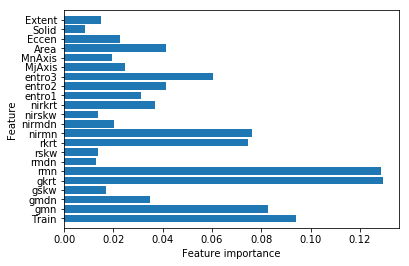

In [16]:
learning.plot_feature_importances(outModel, feat_fields)

It appears as though kurtosis is not contributing much to the results, neither many spatial properties. MjAxis is however, and may be the reason for the spurious tree mapping. Removing it **could** eliminate this issue.



### Now for a pixel based classification using the same training polygons

Bear in mind that the grid search will be much slower as there will be a big rise in the no of training samples

In [4]:
tPix = 'Arundel_train.gz'
msRas = 'Arundel_WWT.tif'

trainPix, rejPix = learning.get_training(segShape, msRas, 3, 'Train', outFile = tPix)

Loading & prepping data


  0%|          | 1/5768 [00:00<10:11,  9.44it/s]

calculating stats


100%|██████████| 5768/5768 [00:06<00:00, 935.57it/s] 


**To use the existing parameters above**

```python
outPixmodel = '/media/ciaran/HD-PZFU3/PyScripts/CLCR_tutorials/Arundel_RF_pix.gz'
learning.create_model(trainPix, outPixmodel, clf='rf', cv=3, params=params)
```
This will, however take an absolute age to process on a laptop (96 model fits)

When using a huge training set 100k + samples, best to use a powerful machine (lots of cores and RAM or HPC.

Also worth bearing in mind that there usually a trade off with different ML algorithms.

Simpler models like logistic regression/maxent, CART, naive bayes will be quick to process on large datasetes but more limited in their scope.

More complex ensemble models such as RF, GB or non-linears like SVM kernels or various neural nets will take longer to compute.

For the sake of brevity here, we will use a very limited parameter set. 



In [5]:
params = {'n_estimators': [500], 'min_samples_split':[5,10], 'min_samples_leaf': [5,10]}

outPixmodel = 'arundelPixModel.gz'

In [ ]:
learning.create_model(trainPix, outPixmodel, clf='rf', cv=3, params=params)

Preparing data
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=500, min_samples_leaf=5, min_samples_split=5 .......
[CV] n_estimators=500, min_samples_leaf=5, min_samples_split=5 .......
[CV] n_estimators=500, min_samples_leaf=5, min_samples_split=5 .......
[CV] n_estimators=500, min_samples_leaf=5, min_samples_split=10 ......
[CV] n_estimators=500, min_samples_leaf=5, min_samples_split=10 ......
[CV] n_estimators=500, min_samples_leaf=5, min_samples_split=10 ......
[CV] n_estimators=500, min_samples_leaf=10, min_samples_split=5 ......
[CV] n_estimators=500, min_samples_leaf=10, min_samples_split=5 ......
[CV] n_estimators=500, min_samples_leaf=10, min_samples_split=5 ......
[CV] n_estimators=500, min_samples_leaf=10, min_samples_split=10 .....
[CV] n_estimators=500, min_samples_leaf=10, min_samples_split=10 .....
[CV] n_estimators=500, min_samples_leaf=10, min_samples_split=10 .....
